El presente documento pretende dar a conocer la realidad de los datos abiertos existentes relacionados con los **funcionarios públicos**, para ello me remití a usar como fuente de análisis los datos publicados por el Consejo Para La Transparencia (CPLT), en su [repositorio](https://www.portaltransparencia.cl/PortalPdT/web/guest/opendata)

La información presentada en este portal corresponde a la de aquellos Servicios Públicos que han adoptado el sistema de publicación de Transparencia Activa que promueve el CPLT, y que por lo tanto, es posible de disponibilizar de manera estándar. En este punto se produce el primer hallazgo del análisis, puesto que de acuerdo a lo señalado por el CPLT, los organismos están obligados a generar portales de Transparencia Activa, esto según la ley 20.285, sin embargo, no se indica en esta ley, que deba ser usando la plataforma que disponibiliza el CPLT, y de la cual se obtienen los datos que son puesto a disponibilidad en el sitio de datos abiertos. Con ellos nos surge de inmediato la siguiente duda, **¿Por qué no usan esta plataforma todos los servicios obligados?**

En los siguientes acápites revisaremos problemáticas asociadas a la coherencia y fiabilidad de la información publicada, que hacen difícil poder sacar conclusiones de la información disponible.

# Diccionario de datos

Uno de los primeros puntos a destacar es la falta de un diccionario en el [repositorio de datos abiertos](https://www.portaltransparencia.cl/PortalPdT/web/guest/opendata), lo que significa una dificultad extra a la hora de poder analizar los datos, ya que se deben hacer supuestos respecto del significado de cada variable, y dichos supuestos se hacen en base a obviamente el nombre dado, el contenido y el contexto, por lo tanto, requieren de un esfuerzo extra y añaden un riesgo de error a los resultados.
- En conclusión como primera sugerencia se invita al CPLT a **añadir un diccionario de variables en su repositorio de datos abiertos**

# Ambiente de análisis de datos

Para los posteriores análisis se asume que el lector ha montado un ambiente de análisis de los datos de funcionarios del sector público provenientes del repositorio de datos abiertos del CPLT, y se encuentran en una base de datos de MySQL.

Para quienes deseen simplificar este paso, en el siguiente [repositorio personal de GitHub](https://www.repositorio.com/actualizaralterminar) se encuentra un notebook llamado "DescargayRespaldo", el cual realiza la descarga, limpieza parcial y posterior carga en la base de datos de los datos, se requiere como prerequisito lo siguiente:

- Tener instalado el gestor de base de datos MySQL en algún servidor accesible por el usuario con permisos de escritura.
- Tener instalado Anaconda Python y creado un ambiente que contenga las siguientes librerías: pandas, numpy, time, date, datetime, functools, urllib, json, mysql.connector, sqlalchemy


# Fechas de publicación

Es esencial para poder comenzar el análisis conocer la periodicidad con que se publica la información, esto porque los datos que se publican son acumulativos, es decir en la medida que se publica una actualización, se añade a la información ya publicada, dentro del mismo archivo.
Actualmente existen en el archivo varios campos que contienen datos de fecha, sin embargo, los que podrían estar relacionados con la fecha de publicación:

- Fecha de publicación:
- Anyo
- Mes

Aparentemente esos tres datos deberían coincidir ya que el Anyo, debería ser el año de publicación, y el mes correspondería al mes de publicación.
En vista de las definiciones anteriores realicé la consulta respectiva para verificar la hipótesis.

In [67]:
import os
os.environ['MYSQL_FUNC_USER'] = 'dbadmin'
os.environ['MYSQL_FUNC_PASS'] = '1'
os.environ['MYSQL_FUNC_HOST'] = '192.168.2.2'
os.environ['MYSQL_FUNC_DB'] = 'chc'

In [68]:
#Importamos las credenciales que usaremos en todo el notebook
import os
user = os.getenv('MYSQL_FUNC_USER')
passwd = os.getenv('MYSQL_FUNC_PASS')
host = os.getenv('MYSQL_FUNC_HOST')
db = os.getenv('MYSQL_FUNC_DB')

In [2]:
import vertica_python
import pandas as pd
import numpy as np

# información de conexión a vertica
conn_info = {'host': '192.168.2.2',
             'port': 5433,
             'user': 'dbadmin',
             'password': '1',
             'database': 'chc',
             # default throw error on invalid UTF-8 results
             'unicode_error': 'strict',
             # SSL is disabled by default
             'ssl': False,
             # using server-side prepared statements is disabled by default
             'use_prepared_statements': False}

# conexión simple con cierre manual
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query1 = '''
SELECT round(SUM(año)/count(año), 4) * 100 as PorcAño, 
round(SUM(Mes)/count(Mes), 4) * 100 as PorcMes,
round((SUM(año) + SUM(Mes))/(count(año)*2), 4) * 100 as PorcAmbos
FROM (
SELECT 
CASE WHEN f.anyo = YEAR(date(fechapublicacion) ) then 0 else 1 end as año,
CASE WHEN to_number(MesN) = month(date(fechapublicacion)) then 0 else 1 end as Mes 
FROM funcionarios."full" f 
) as t
'''

df1 = pd.read_sql(query1, cnxn)

cnxn.close()

Al revisar el porcentaje de coincidencia de fechas, año y mes vemos que el año de la fecha de publicación y el campo año difieren en un **{{df1['PorcAño'][0]}}%** las veces, asimismo, el campo mes tiene una divergencia del mes de publicación de **{{df1['PorcMes'][0]}}%** y un **{{df1['PorcAmbos'][0]}}%** en que ambos difieren.

Por lo que, es posible afirmar que estos campos no se encuentran relacionados. Frente a esto se hace necesario determinar cual campo representa de mejor manera la fecha de publicación.

La mejor forma de lograr esta estimación se obtiene luego de visitar cualquier sitio de transparencia de los servicios que usan la plataforma, en este caso lo hice con la Subsecretaría de Salud Pública, para verificarlo realicé los siguiente:

- Ingresé a la [página de la subsecretaría](https://www.minsal.cl/)
- Bajé hasta encontrar el banner de Transparencia Activa, [pinché](https://www.portaltransparencia.cl/PortalPdT/pdtta?codOrganismo=AO001)
- Finalmente dentro del sitio, seleccioné [Personal a Contrata](https://www.portaltransparencia.cl/PortalPdT/pdtta/-/ta/AO001/PR/PCONT), luego [2020](https://www.portaltransparencia.cl/PortalPdT/pdtta/-/ta/AO001/PR/PCONT/46305762), y finalmente [Marzo](https://www.portaltransparencia.cl/PortalPdT/pdtta/-/ta/AO001/PR/PCONT/46305831)

Dentro de la dirección descrita, se presenta una página como la mostrada en la imagen 1, donde queda en evidencia que los campos Anyo y Mes son los que se utilizan para definir el periodo o fecha de publicación.

***Imagen 1: Página de Transparencia Activa de la Subsecretaría de Salud Pública, sección Personal Contrata, 2020, Marzo***
<img src="img/image1.png">


## Distribución de las fechas de publicación

Asumiendo entonces, en base a los resultados de la sección anterior, que los campos Anyo y Mes son los adecuados para analizar la fecha de publicación, surge otro de los puntos de interés, el cual corresponde a los años y meses que se han reportado, analizando cosas como desde cuando se ha reportado, y cuanta información se ha reportado.

In [85]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query2 = '''
SELECT f.anyo , f.Mes , count(*) as 'count(f.`index` )'
FROM funcionarios."full" f 
GROUP BY f.anyo , f.Mes, mesN
order by f.anyo, mesN asc
'''

df2 = pd.read_sql(query2, con=cnxn)

db_connection.close()

df2['mesAño'] = df2['anyo'].astype(str) + '-' + df2['Mes']

cnxn.close()

***Figura 1: Distibución de registros por Año-Mes***

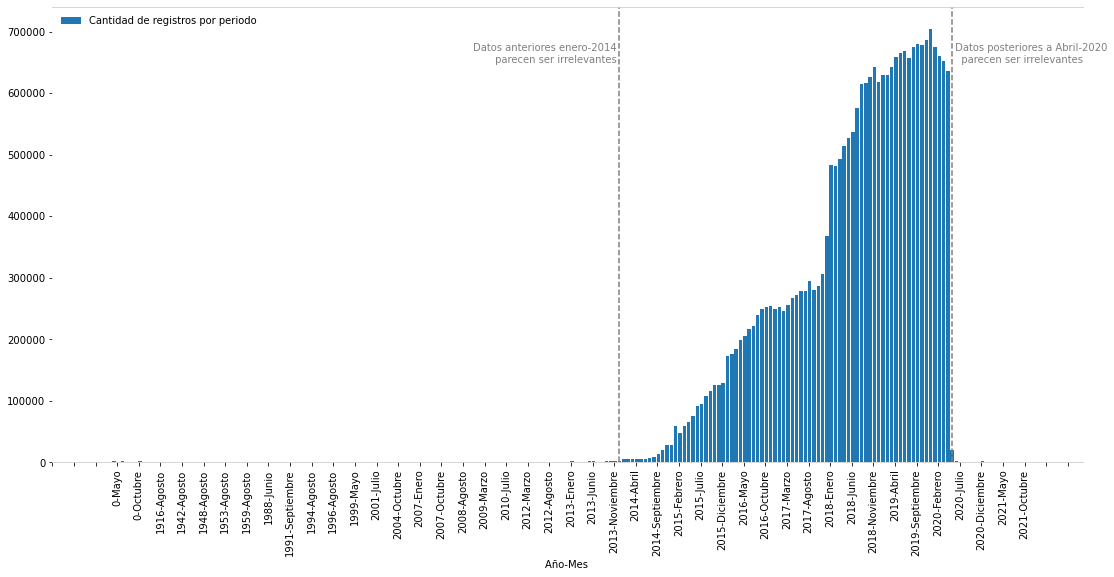

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown

y = df2['count(f.`index` )']
x = df2['mesAño']

fig, ax = plt.subplots(figsize=(15,7))
plt.xticks(rotation =90)
plt.tight_layout() 
plt.bar(x, y)
stepsize = 5
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax.set_xlabel('Año-Mes ')

# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(['Cantidad de registros por periodo'], loc = 'upper left', shadow = False, edgecolor = 'white')

plt.text(df2['mesAño'][df2[df2['mesAño'] == '2013-Diciembre'].index.values[0]], 650000,\
         'Datos anteriores enero-2014 \n parecen ser irrelevantes ', color = 'grey',\
        horizontalalignment='right')

plt.text(df2['mesAño'][df2[df2['mesAño'] == '2020-Mayo'].index.values[0]], 650000,\
         ' Datos posteriores a Abril-2020\n   parecen ser irrelevantes', color = 'grey',\
        horizontalalignment='left')
display(Markdown('***Figura 1: Distibución de registros por Año-Mes***'))
ax.axvline(x='2013-Diciembre', color = 'grey', ls = '--')
ax.axvline(x='2020-Mayo', color = 'grey', ls = '--')
plt.show()


Como se aprecia en la figura 1, los datos presentan considerables problemas, pues se tienen registros desde el año 0 hasta 2021, y pese a que son pocos los registros que están asociados a un año fuera de los normal, su sola existencia ya genera alteraciones. 

Por otro lado, se aprecia en el gráfico que a partir de enero de 2014 ya comienzan a aparecer una cantidad de registros importantes (más de 10.000), y desde entonces el sistema ha ido aumentando la cantidad de registros por cada periodo.
Este gráfico nos deja claro que será necesario considerar un filtro que excluya del análisis datos previos a 2014 y posteriores al último mes con una cantidad de registro similar a la tendencia de los último tres meses ya cerrados, en este caso es marzo 2020.


# ¿Quiénes informan?

El siguiente punto a analizar corresponde a conocer cuáles son los Servicios que informan a través del sistema de transparencia activa que promueve el CPLT, y describiendo el comportamiento de información de estos.
Lo primero es saber que Servicios están obligados a informar vía Transparencia Activa, para ello el CPLT dispone de un **[listado](https://www.portaltransparencia.cl/PortalPdT/web/guest/opendata#_48_INSTANCE_GI66ozEZ7DNy_=dataset%2Forganismos%2Fresource%2F527e355d-f401-48c7-b984-2d2971db9713)** accesible en sus página de datos abiertos, el cual será la base para conocer quiénes informan utilizando la plataforma del CPLT y quienes no.

## Servicios Obligados
La Ley 20.285 es la que establece que Servicios están obligados a informar a través de transparencia activa y quienes quedan excluidos, específicamente en el [articulo 2º](https://www.leychile.cl/Navegar?idNorma=276363).
El problema es que ese artículo enumera a los Servicios de manera genérica, por ejemplo, señala: 
>Las disposiciones de esta ley serán aplicables a los ministerios, las intendencias, las gobernaciones, los gobiernos regionales, las municipalidades, las Fuerzas Armadas, de Orden y Seguridad Pública, y **los órganos y servicios públicos creados para el cumplimiento de la función administrativa**.

Como se puede apreciar en lo que está resaltado no se da en la ley un listado extensivo.

Realizando diferentes búsquedas, no fue posible encontrar aproximaciones aceptables de ese listado, por lo que utilizaremos el **[listado](https://www.portaltransparencia.cl/PortalPdT/web/guest/opendata#_48_INSTANCE_GI66ozEZ7DNy_=dataset%2Forganismos%2Fresource%2F527e355d-f401-48c7-b984-2d2971db9713)** que disponibiliza el CPLT como proxy de ese listado.

In [87]:
df3 = pd.read_csv(
    'http://www.cplt.cl/transparencia_activa/datoabierto/archivos/Organismos_360.csv',
    encoding='cp1252',
    sep = ';')

In [128]:
qServ = df3['Codigo_org'].count()
qOblig = df3[df3['obligadorecibir_sai']=='SÍ']['Codigo_org'].count()
qObligInt = df3[(df3['obligadorecibir_sai']=='SÍ')&(df3['interopera']=='SÍ')]['Codigo_org'].count()
porcOI = round(float(qObligInt) / float(qOblig) * 100.0, 2)
display(Markdown('En este listado se declaran **{} Instituciones**, donde además vemos que existe un campo que aparentemente \
señala aquellos que realmente están obligados (obligadorecibir_sai), según este campo, los obligados serían \
**{} Instituciones**, además el campo "interopera" aparentemente entrega la información respecto a si los organismos\
 informan usando la plataforma promovida por el CPLT, y de acuerdo a esto aquellos que estarían obligados y que además\
 interoperan serían **{} Instituciones**, es decir un {}%'.format(qServ, qOblig,qObligInt, porcOI)))

En este listado se declaran **966 Instituciones**, donde además vemos que existe un campo que aparentemente señala aquellos que realmente están obligados (obligadorecibir_sai), según este campo, los obligados serían **897 Instituciones**, además el campo "interopera" aparentemente entrega la información respecto a si los organismos informan usando la plataforma promovida por el CPLT, y de acuerdo a esto aquellos que estarían obligados y que además interoperan serían **107 Instituciones**, es decir un 11.93%

In [89]:
from ipypublish import nb_setup

display(Markdown('Estas instituciones quedarían distribuidas según categoría de la siguiente manera:'))
display(Markdown('***Tabla 1: distribución de instituciones que están obligadas a disponer Transparencia Activa***'))
qOblig = df3[df3['obligadorecibir_sai']=='SÍ']
tablaT1 = qOblig.groupby(by = ['Padre_org'])['Codigo_org'].count().reset_index()

qObligInt = df3[(df3['obligadorecibir_sai']=='SÍ')&(df3['interopera']=='SÍ')]
tablaT2 = qObligInt.groupby(by = ['Padre_org'])['Codigo_org'].count().reset_index()

tabla1 = tablaT1.merge(tablaT2, how = 'left', left_on = 'Padre_org', right_on = 'Padre_org').fillna(0)

tabla1 = tabla1.rename(columns = {'Codigo_org_x': 'Obligados'
                                  , 'Codigo_org_y': 'Obligados que Interoperan'
                                  , 'Padre_org': 'Categoría'})

tabla1 = tabla1.append(tabla1.sum(numeric_only=True), ignore_index=True)
tabla1['Categoría'] = tabla1['Categoría'].fillna('Total')

from tabulate import tabulate

display(Markdown(tabulate(tabla1, headers='keys', tablefmt='pipe', showindex=False)))

Estas instituciones quedarían distribuidas según categoría de la siguiente manera:

***Tabla 1: distribución de instituciones que están obligadas a disponer Transparencia Activa***

| Categoría                                               |   Obligados |   Obligados que Interoperan |
|:--------------------------------------------------------|------------:|----------------------------:|
| Agricultura                                             |          11 |                           0 |
| Asociación Municipal                                    |          57 |                           0 |
| Bienes Nacionales                                       |           1 |                           1 |
| Centro de Formación Técnica                             |           8 |                           0 |
| Ciencia Tecnología e Innovación                         |           1 |                           0 |
| Congreso Nacional                                       |           3 |                           0 |
| Consejo Defensa del Estado                              |           1 |                           0 |
| Consejo Fiscal Autónomo                                 |           1 |                           0 |
| Consejo de Cultura y Artes                              |           1 |                           0 |
| Consejo para la Transparencia                           |           1 |                           0 |
| Contraloría de la República                             |           1 |                           0 |
| Corporaciones Municipales                               |          57 |                           0 |
| Culturas y las Artes                                    |           3 |                           1 |
| Defensa Nacional                                        |          13 |                           0 |
| Defensoría de los Derechos de la Niñez                  |           1 |                           0 |
| Deporte                                                 |           2 |                           0 |
| Desarrollo Social                                       |           8 |                           0 |
| Economía Fomento y Turismo                              |          15 |                           2 |
| Educación                                               |          23 |                           1 |
| Empresas y Sociedades                                   |           4 |                           0 |
| Energía                                                 |           4 |                           0 |
| Fundaciones y corporaciones                             |           9 |                           0 |
| Hacienda                                                |          12 |                           2 |
| Instituto Derechos Humanos                              |           1 |                           0 |
| Instituto Nacional de Hidráulica (INH)                  |           1 |                           0 |
| Interior y Seguridad Pública                            |          97 |                          69 |
| Justicia                                                |          11 |                           0 |
| La Mujer y Equidad de Género                            |           2 |                           0 |
| Medio Ambiente                                          |           3 |                           0 |
| Minería                                                 |           3 |                           0 |
| Municipios de Antofagasta                               |           9 |                           0 |
| Municipios de Arica y  Parinacota                       |           4 |                           0 |
| Municipios de Atacama                                   |           9 |                           0 |
| Municipios de Aysen del General Carlos Ibáñez del Campo |          10 |                           0 |
| Municipios de Coquimbo                                  |          15 |                           0 |
| Municipios de La Araucanía                              |          32 |                           0 |
| Municipios de Los Lagos                                 |          30 |                           0 |
| Municipios de Los Ríos                                  |          12 |                           0 |
| Municipios de Magallanes y de la Antártica Chilena      |          10 |                           0 |
| Municipios de R. Metropolitana de Santiago              |          52 |                           0 |
| Municipios de Tarapacá                                  |           7 |                           0 |
| Municipios de Valparaíso                                |          38 |                           0 |
| Municipios de Ñuble                                     |          21 |                           0 |
| Municipios del Bíobio                                   |          33 |                           0 |
| Municipios del Libertador General Bernardo OHiggins     |          33 |                           0 |
| Municipios del Maule                                    |          30 |                           0 |
| Obras Públicas                                          |          12 |                          12 |
| Partidos Políticos                                      |           9 |                           0 |
| Poder Judicial                                          |           1 |                           0 |
| Presidencia de la República                             |           1 |                           0 |
| Relaciones Exteriores                                   |           7 |                           0 |
| Salud                                                   |         112 |                           0 |
| Secretaría General de Gobierno                          |           2 |                           0 |
| Secretaría General de la Presidencia                    |           1 |                           0 |
| Servicio Electoral                                      |           1 |                           0 |
| Superintendencia de Servicios Sanitarios                |           1 |                           0 |
| Trabajo y Previsión Social                              |          10 |                           2 |
| Transportes y Telecomunicaciones                        |           3 |                           0 |
| Tribunal Constitucional                                 |           1 |                           0 |
| Universidades                                           |          18 |                           0 |
| Vivienda y Urbanismo                                    |          18 |                          17 |
| Total                                                   |         897 |                         107 |

## Cantidad de Servicios que han informado

De acuerdo a la sección anterior, 107 son los servicios que informan, sin embargo, de ser así esto no ha sido así siempre a través del tiempo, o al menos eso se sospecha a partir de la figura 1.
Para ratificar que mi sospecha fuera correcta, generé la figura 2, en ella se puede ver a través del tiempo, como se han ido incorporando instituciones a la plataforma (para este análisis solo se tomaron datos cuya fecha fuera superior a diciembre 2013 y menor a abril 2020)

***Figura 2: Evolución de Servicios que utilizan la plataforma del CPLT para disponer su información de Transparencia Activa***


In [98]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query4 = '''
SELECT DISTINCT anyo, mesN, OrganismoCodigo
FROM funcionarios."full" f 
WHERE anyo  > 2013
AND anyo * 100 + mesN < 202005
'''

df4 = pd.read_sql(query4, con=cnxn)

cnxn.close()

df4 = df4.rename(columns = {'OrganismoCodigo': 'organismo_codigo'})

In [99]:
# creación del campo año mes
df4['mesAño'] = df4['anyo'].astype(str) + '-' + df4['mesN'].astype(str)
# unión con df que describe a los servicios

df4M = df4.merge(df3, how = 'left', left_on = 'organismo_codigo', right_on = 'Codigo_org')
# filtrado por solo los obligados
df4F = df4M[df4M['obligadorecibir_sai'] == 'SÍ']
# conteo de los servicios que publican información mensual
df4G = df4F.groupby('mesAño')['organismo_codigo'].nunique().reset_index()

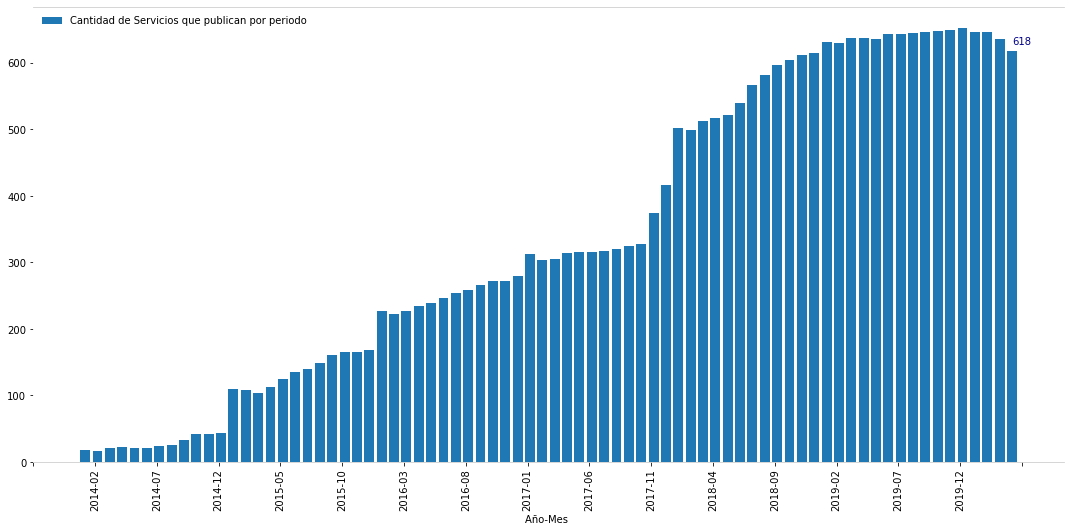

In [100]:
#---------------------
# Grafico 2
#---------------------

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown

y = df4G['organismo_codigo']
x = df4G['mesAño']

fig, ax = plt.subplots(figsize=(15,7))
plt.xticks(rotation =90)
plt.tight_layout() 
plt.bar(x, y)
stepsize = 5
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax.set_xlabel('Año-Mes ')

# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(['Cantidad de Servicios que publican por periodo'], loc = 'upper left', shadow = False, edgecolor = 'white')

plt.text(df4G['mesAño'][df4G[df4G['mesAño'] == '2020-04'].index.values[0]],df4G['organismo_codigo'][df4G[df4G['mesAño'] == '2020-04'].index.values[0]] +10,\
         str(df4G['organismo_codigo'][df4G[df4G['mesAño'] == '2020-04'].index.values[0]]), color = 'darkblue',\
        horizontalalignment='left')

plt.show()

Como podemos apreciar en la figura 2, la cantidad de instituciones que publican información en la plataforma del CPLT ha ido creciendo considerablemente, y de hecho, superan con creces las 107 declaradas en  el **[listado](https://www.portaltransparencia.cl/PortalPdT/web/guest/opendata#_48_INSTANCE_GI66ozEZ7DNy_=dataset%2Forganismos%2Fresource%2F527e355d-f401-48c7-b984-2d2971db9713)**, por lo que quizás esté mal interpretando el significado de lo que significa el campo "interopera" o simplemente los datos no se encuentran actualizados. Cualquiera sea el caso, el punto es que en la plataforma se encuentran publicando una cantidad considerable de servicios obligados, sin embargo, de los 895, aún faltan más de 200 por incorporarse.
Aquí surge una duda, aquellos Servicios que no publicaron corresponde a instituciones que no utilizan las plataforma y por lo tanto, sus datos nunca han estado en el dataset, o hay servicios que informan de manera intermitente. Mirando la figura 2 se aprecia que la respuesta debe estar compuesta por un poco de ambas afirmaciones, ya que, en marzo 2020 informaron menos Servicios que en febrero del mismo año, por lo que hay Servicios que no informaron en el último mes pero que si lo hicieron el mes anterior. Asimismo, nunca se ha alcanzado el máximo de 895 Servicios, por lo que deben haber instituciones que no se han informado nunca porque no están integrados en la plataforma del CPLT.

En la tabla 2 se presentan los Servicios que algunas vez informaron a través del dataset, pero que en marzo no tienen registros.

In [131]:
# Dividimos el dataset en dos, los que han publicado antes del último mes y los del último mes
df4FFeb = df4F[df4F['mesAño'] != '2020-04']
df4FFeb = df4FFeb['organismo_codigo'].drop_duplicates().to_frame()
df4FMar = df4F[df4F['mesAño'] == '2020-04']
df4FMar = df4FMar['organismo_codigo'].drop_duplicates().to_frame()
df4FMar = df4FMar.rename(columns = {'organismo_codigo': 'orgcode'})

# Unimos los dataset para ver las diferencias entre uno y otro
df4NotP = df4FFeb.merge(df4FMar, how = 'left', left_on = 'organismo_codigo', right_on = 'orgcode')
df4NotP = df4NotP[df4NotP['orgcode'].isnull()]
nombresS = df3[['Codigo_org', 'Organismo']]
df4NotP = df4NotP.merge(nombresS, how = 'left', left_on = 'organismo_codigo', right_on = 'Codigo_org')
df4NotP = df4NotP[df4NotP['Organismo'].notnull()]

# Imprimimos en 3 columnas
d = df4NotP['Organismo'].reset_index().drop(columns = {'index'})
d.index = pd.MultiIndex.from_tuples(d.index.map(lambda x: (x//25, x%25)))
df4NotPP = d.unstack(0).fillna('')
headers = ['', '', '', '', '']
df4NotPP.to_csv('nopublican.csv', encoding = 'cp1252')
display(Markdown('***Tabla 2: Servicios que han publicado datos en el dataset, pero que no publicaron el último mes***'))
display(Markdown(df4NotPP.to_latex(header = False, index = False, column_format = ' p{5cm} | p{5cm} | p{5cm} ')))

***Tabla 2: Servicios que han publicado datos en el dataset, pero que no publicaron el último mes***

\begin{tabular}{ p{5cm} | p{5cm} | p{5cm} }
\toprule
                            Municipalidad de Maule &                Corporación Municipal Isla de Maipo &           Corporación Municipal de Maipú (CODEDUC) \\
                         Municipalidad de Porvenir &                       CFT de la Región de Coquimbo &                     Municipalidad de Independencia \\
                          Municipalidad de Iquique &               Hospital Mauricio Heyermann de Angol &                         Municipalidad de El Carmen \\
                           Municipalidad de Retiro &                          Municipalidad de Colchane &  Dirección Nacional de Fronteras y Límites del ... \\
                   Corporación Municipal de Pirque &                           Hospital Roberto del Río &  Asociación de Municipalidades Territorio de Ri... \\
                        Municipalidad de Río Verde &                       SEREMI de Salud de Los Lagos &  Asociación de Municipalidades Desarrollo Apicu... \\
                       Municipalidad de Llanquihue &  Dirección General de Relaciones Económicas Int... &  Fundación de Comunicación Capacitación y Cultu... \\
                            Municipalidad de Putre &                               Gendarmería de Chile &  Ex Consejo Nacional de la Cultura y las Artes ... \\
    Asociación de Municipalidades Nahuelbuta (AMN) &   Asociación de Municipalidades del Norte de Chile &                               Carabineros de Chile \\
                        Municipalidad de Llay Llay &                      CFT de la Región de los Lagos &  Asociación Municipalidades Provincia de Llanqu... \\
 Gobierno Regional de La Araucanía (Gore Arauca... &        Servicio Nacional del Adulto Mayor (SENAMA) &                            Municipalidad de Vicuña \\
                         Municipalidad de Litueche &  Asociación de Municipalidades de la Región de ... &  Asociación de Municipalidades del Valle del Maipo \\
                          Municipalidad de Carahue &  Asociación de Municipios Cordillera de la Cost... &  Asociación de Municipalidades para la Preserva... \\
                         SERVIU Región de Coquimbo &                            Municipalidad de Camiña &                                                    \\
                           Municipalidad de Malloa &                            Municipalidad de Antuco &                                                    \\
                           Municipalidad de Ninhue &                           Municipalidad de Negrete &                                                    \\
                    Corporación Municipal de Ancud &  Asociación de Municipalidades Paisajes de Cons... &                                                    \\
 Asociación de Municipalidades de la Provincia ... &                       Municipalidad de Santa María &                                                    \\
                         Municipalidad de Valdivia &                        Municipalidad de Puchuncaví &                                                    \\
                       SEREMI de Salud del Bío Bío &                             Defensa Civil de Chile &                                                    \\
                          Municipalidad de Cochamó &  Asociación de Municipalidades de la Provincia ... &                                                    \\
                      Municipalidad de San Ignacio &                         Municipalidad de Melipilla &                                                    \\
                     Municipalidad de San Fernando &  Superintendencia de Bancos e Instituciones Fin... &                                                    \\
                        Municipalidad de Vichuquén &  Asociación de Municipalidades Quinta Región Co... &                                                    \\
                           Universidad de Ohiggins &                          Municipalidad de Vallenar &                                                    \\
\bottomrule
\end{tabular}


Por otro lado tenemos los Servicios que nunca han informado en el dataset, probablemente debido a que no están integrados en la plataforma que dispone el CPLT.

Estos alcanzan la cifra de 216 de los 895, es decir, aún falta que un 24% de los Servicios se incorpore a la plataforma.
En el anexo 1 se encuentra el detalle de los Servicios que nunca ha publicado en el dataset.

Como vemos hay una gran cantidad de Servicios que ya reportan por la plataforma del CPLT, pero aún faltan algunos que son de tamaño considerable, como el Servicio de Impuestos Internos o la Contraloría General entre otros, por lo que se hace un llamado a estas instituciones a hacer los esfuerzos necesarios para incorporarse a la plataforma.

## Regularidad de Publicación de los Servicios

Otro punto importante es la regularidad con que los servicios publican su información, para ello se elaboró un indicador para rankear los más  y los menos regulares. El indicador es simple, y se calcula de la siguiente manera:

a: Cantidad de veces que ha publicado desde la primera publicación

b: Cantidad de periodos ocurridos desde la primera publicación

$$\frac{a}{b}*100$$

In [102]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
qPeriodos = '''
SELECT anyo , mesN , OrganismoCodigo as organismo_codigo , OrganismoNombre as organismo_nombre 
FROM funcionarios."full" f 
WHERE anyo  > 2013
AND anyo * 100 + mesN < 202005
'''

dfPer = pd.read_sql(qPeriodos, con=cnxn)

cnxn.close()

In [134]:
#Variable año mes
dfPer['fecha'] = pd.to_datetime(dfPer['anyo'].astype(str)+'/'+dfPer['mesN'].astype(str))

In [135]:
dfPer.head()

,anyo,mesN,organismo_codigo,organismo_nombre,fecha
0,2019,04,MU342,Municipalidad De Yerbas Buenas,2019-04-01
1,2019,04,MU342,Municipalidad De Yerbas Buenas,2019-04-01
2,2019,04,MU342,Municipalidad De Yerbas Buenas,2019-04-01
3,2020,04,MU342,Municipalidad De Yerbas Buenas,2020-04-01
4,2020,04,MU342,Municipalidad De Yerbas Buenas,2020-04-01


In [136]:
#Calculo de periodos que debería haber publicado
dfMesIni = dfPer.groupby(by=['organismo_codigo'])['fecha'].min().reset_index()
dfMesIni['max'] = pd.to_datetime('2020-05-01')
dfMesIni['diff'] = (dfMesIni['max'] - dfMesIni['fecha'])
dfMesIni['diff'] = round(dfMesIni['diff']/np.timedelta64(1,'M') + 1)


In [137]:
#Calculo de peridos que ha publicado
dfPubl = dfPer.groupby(by=['organismo_codigo'])['fecha'].nunique().reset_index().rename(columns={'fecha':'Qpublica'})

In [138]:
# Merges y filtros para obtener dataset final
dfRegula = dfMesIni.merge(dfPubl, how = 'left', left_on = 'organismo_codigo', right_on = 'organismo_codigo')
dfRegula['indicador'] = round(dfRegula['Qpublica']/dfRegula['diff'] * 100, 1)
df4TotalF = df3[df3['obligadorecibir_sai'] == 'SÍ']
dfRegula = dfRegula.merge(df4TotalF, how = 'inner', left_on = 'organismo_codigo', right_on = 'Codigo_org')
dfRegula = dfRegula[['organismo_codigo', 'fecha', 'diff', 'Qpublica','indicador', 'Organismo']]

dfRegula = dfRegula.sort_values(by = 'indicador', ascending = True)

In [139]:
# Calculo de variables a usar en parrafo
novel = int(min(dfRegula['diff']))
qnovel = int(len(dfRegula[dfRegula['diff'] == novel]))
noveles = dfRegula[dfRegula['diff'] == novel]
noveles = noveles[['Organismo']].sort_values(by = 'Organismo')

old = int(max(dfRegula['diff']))
qold = int(len(dfRegula[dfRegula['diff'] == old]))
olds = dfRegula[dfRegula['diff'] == old]
olds = olds[['Organismo']].sort_values(by = 'Organismo')

maximo = int(len(dfRegula[dfRegula['indicador'] == 100]))
hanpubli = len(dfRegula)
porcentaje = round(maximo / hanpubli * 100, 2)

peores = dfRegula[['Organismo', 'indicador']].head(25)

In [151]:
dfRegula

,organismo_codigo,fecha,diff,Qpublica,indicador,Organismo
578,MU229,2014-07-01,71.0,1,1.4,Municipalidad de Puchuncaví
449,MU083,2015-06-01,60.0,1,1.7,Municipalidad de El Carmen
298,CM007,2016-06-01,48.0,1,2.1,Corporación Municipal de Maipú (CODEDUC)
670,MU335,2017-01-01,41.0,1,2.4,Municipalidad de Vicuña
28,AD009,2014-04-01,74.0,2,2.7,Carabineros de Chile
...,...,...,...,...,...,...
572,MU222,2014-01-01,77.0,76,98.7,Municipalidad de Pitrufquén
546,MU193,2014-01-01,77.0,76,98.7,Municipalidad de Padre Hurtado
465,MU100,2014-01-01,77.0,76,98.7,Municipalidad de Graneros
516,MU161,2014-01-01,77.0,76,98.7,Municipalidad de Macul


Antes de pasar a revisar el ranking, es importante dar un poco de contexto de las cifras, por ejemplo, existen **{{qnovel}}** Servicios que se incorporaron al dataset hace sólo **{{novel}}** meses publicando información, estos son los que aparecen en la tabla 3: 

**Tabla 3: Servicios que se incorporaron recientemente al dataset**

In [141]:
display(Markdown(noveles.to_latex(header = False, index = False)))

\begin{tabular}{l}
\toprule
 Dirección de Compras y Contratación Pública (C... \\
                        Hospital Exequiel González \\
                      SERVIU Región de Antofagasta \\
\bottomrule
\end{tabular}


Por otro lado tenemos los Servicios que llevan mucho tiempo en la plataforma, estos ascienden a **{{qold}}** Servicios que se incorporaron hace **{{old}}** meses al dataset, estos son los que aparecen en la tabla 4:


**Tabla 4: Servicios con mayor antigüedad de incorporación al dataset**

In [150]:
pd.set_option('display.max_colwidth', -1)
olds.iloc[1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


Organismo    Corporación Municipal de Educación y Servicios Ramón Freire Dalcahue
Name: 302, dtype: object

In [142]:
display(Markdown(olds.to_latex(header = False, index = False)))

\begin{tabular}{l}
\toprule
 Asociación de Municipalidades Paisajes de Cons... \\
 Corporación Municipal de Educación y Servicios... \\
                      Municipalidad de Antofagasta \\
                          Municipalidad de Calbuco \\
                         Municipalidad de Graneros \\
                        Municipalidad de La Granja \\
                        Municipalidad de Los Andes \\
                            Municipalidad de Macul \\
                    Municipalidad de Padre Hurtado \\
                            Municipalidad de Peumo \\
                         Municipalidad de Peñaflor \\
                       Municipalidad de Pitrufquén \\
                         Municipalidad de Porvenir \\
                        Municipalidad de Quilicura \\
                         Municipalidad de Requínoa \\
                        Municipalidad de Rio Bueno \\
                      Municipalidad de San Rosendo \\
                     Municipalidad de Sierra Gorda \\
\bottomrule
\end{tabular}


Adicionalmente respecto de este contexto, es importante señalar que existen **{{maximo}}** Servicios que han publicado en todos los periodos desde que se incorporaron al dataset, esto corresponde a un **{{porcentaje}}**% de los {{hanpubli}} que alguna vez han publicado. En el anexo 2 se encuentra el listado detallado de estos Servicios.

Finalmente en la tabla 5 se presentan los 25 Servicios peor rankeados en el indicador, es decir que porcentualmente menos han publicado.

**Tabla 5: Servicios que con peor indicador de regularidad de publicación.**

In [172]:
peores.to_csv('peores.csv', sep = ';', encoding = 'cp1252')

In [110]:
display(Markdown(peores.to_latex(header = False, index = False)))

\begin{tabular}{lr}
\toprule
                       Municipalidad de Puchuncaví &   1.4 \\
                        Municipalidad de El Carmen &   1.7 \\
          Corporación Municipal de Maipú (CODEDUC) &   2.1 \\
                           Municipalidad de Vicuña &   2.5 \\
                              Carabineros de Chile &   2.7 \\
 Asociación de Municipalidades del Valle del Maipo &   2.9 \\
 Asociación Municipalidades Provincia de Llanqu... &   3.3 \\
 Asociación de Municipalidades Territorio de Ri... &   4.0 \\
 Asociación de Municipalidades para la Preserva... &   5.9 \\
                          Municipalidad de Pelarco &   8.3 \\
 Asociación de Municipalidades Desarrollo Apicu... &   9.1 \\
 Ex Consejo Nacional de la Cultura y las Artes ... &  14.3 \\
                      Municipalidad de Santa María &  14.3 \\
                            Defensa Civil de Chile &  16.0 \\
 Dirección General de Relaciones Económicas Int... &  16.7 \\
                    Municipalidad de Independencia &  25.0 \\
 Dirección Nacional de Fronteras y Límites del ... &  33.3 \\
                Subsecretaría de Transportes (MTT) &  35.3 \\
                         Municipalidad de Valdivia &  37.3 \\
 Asociación de Municipalidades Paisajes de Cons... &  40.8 \\
 Asociación de Municipalidades de la Provincia ... &  42.1 \\
 Asociación Municipal para la sustentabilidad a... &  46.4 \\
 Asociación de Municipalidades Quinta Región Co... &  46.7 \\
 Fundación de Comunicación Capacitación y Cultu... &  50.0 \\
                  Municipalidad de Sagrada Familia &  60.7 \\
\bottomrule
\end{tabular}


# Falta de estandarización de datos

Como último punto a analizar, se revisó el estado de la estandarización de algunos de los principales campos de descriptivos de cada uno de los funcionarios pertenecientes al dataset.
Entiendase como estandarización al nivel de ordenamiento y agrupación de datos similares, ejemplo: si el campo profesión tiene entre sus valores los siguiente: Ingeniero Comercial MBA en Universidad xX, Ingeniero Comercial Mención Economía. Entonces nos encontramos con un campo "profesión" con bajo nivel de estandarización, esto probablemente se debe a que el ingreso de estos datos es digitado y no a partir de una lista pregenerada.
Entre los campos que se analizaron están: 

- Tipo Estamento
- Tipo Cargo
- Grado
- Tipo de Calificación

## Tipo de Estamento

In [112]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
sqlEstamento = '''
SELECT distinct TipoEstamento
FROM funcionarios."full" f 
'''
estamentos = pd.read_sql(sqlEstamento , con = cnxn)

cnxn.close()

In [114]:
cantTE = len(estamentos)
estClaros = estamentos.sort_values('TipoEstamento').head()
estRaros = estamentos.sort_values('TipoEstamento').tail()

El primer campo analizado corresponde a Tipo de Estamento, el cual contiene información respecto del estamento al cual pertenece el funcionario. 
Actualmente ese campo contiene {{cantTE}} elementos distintos, lo que pareciera ser un número bastante razonable de elementos, sin y de hecho si vemos los primeros 5 elementos, que aparecen en la tabla 6, podríamos pensar que así es, si embargo, en la  tabla 7 se muestran los últimos 5 elementos, y ahí la calidad de la información acerca del Estamento no es tan evidente, ya que hay elementos como "Técnico", "Técnicopedagógico", "Técnico de Salud" y "Técnicos de nivel superior", que aparentemente podrían estar agrupados en un estamento más genérico.

In [115]:
display(Markdown('**Tabla 6:  primeros cinco elementos del campo Tipo Estamento**'))
display(Markdown(estClaros.to_latex(header = False, index = False)))

**Tabla 6:  primeros cinco elementos del campo Tipo Estamento**

\begin{tabular}{l}
\toprule
 (1) Presidente del Consejo Directivo \\
                       Administrativo \\
             Administrativos de Salud \\
                              Alcalde \\
                Autoridad de Gobierno \\
\bottomrule
\end{tabular}


In [116]:
display(Markdown('**Tabla 7:  últimos cinco elementos del campo Tipo Estamento**'))
display(Markdown(estRaros.to_latex(header = False, index = False)))

**Tabla 7:  últimos cinco elementos del campo Tipo Estamento**

\begin{tabular}{l}
\toprule
                                 Técnico \\
                       Técnicopedagógico \\
                       Técnicos de Salud \\
 Técnicos de nivel superior (Ley 19.378) \\
                                    None \\
\bottomrule
\end{tabular}


## Tipo Cargo

In [117]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
sqlCargo = '''
SELECT distinct TipoCargo
FROM funcionarios."full" f 
'''
cargos = pd.read_sql(sqlCargo , con = cnxn)

cnxn.close()

In [118]:
cantTC = len(cargos)
carClaros = cargos.sort_values('TipoCargo').head(20)

El campo Tipo Cargo, el cual aparentemente contiene información respecto del **nombre del cargo** al cual pertenece el funcionario. 
Actualmente ese campo contiene **{{cantTC}}** elementos distintos, lo que pareciera ser un número inmanejable de elementos como para efectivamente realizar algún tipo de análisis, y esto probablemente se deba a la falta de estandarización del campo, de hecho en la tabla 8, se puede ver una muestra de los que se encuentra en ese campo, y se puede apreciar que efectivamente los datos contiene bajo nivel de estandarización, y mucho dato mal ingresado. En conclusión se requiere hacer una análisis respecto de este campo para que se cree una lista seleccionable que permita generar información comparable entre las distintas instituciones.

In [119]:
display(Markdown('**Tabla 8: muestra de 25 elementos del campo Tipo Cargo**'))
display(Markdown(carClaros.to_latex(header = False, index = False)))

**Tabla 8: muestra de 25 elementos del campo Tipo Cargo**

\begin{tabular}{l}
\toprule
                                    (01)Chero \\
                                    (1)+I8:L9 \\
            (131)(26)(51)(37)(43)(46)(08)(09) \\
            (A999 ) Departamento De Educacion \\
                 (C095 ) Liceo De La Frontera \\
        (C950 ) Liceo La Frontera Educ. Media \\
                        (F1051) Escuela Rihue \\
                       (F1052) Escuela Coigue \\
                  (G1049) Escuela De Vaqueria \\
               (S) Director Seguridad Publica \\
 (Servicio De Orientación Médico Estadístico) \\
                               ************** \\
                       ********************** \\
                    ************************* \\
                   ************************** \\
            *Tec En Tto Y Transporte Publicio \\
                                            . \\
      . Encargado  Escuela Rural La Illahuape \\
        . Profesor Filosofía Y Religión Liceo \\
                                            0 \\
\bottomrule
\end{tabular}


## Grados

In [120]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
sqlGrado = '''
SELECT distinct GradoEus
FROM funcionarios."full" f 
'''
grados = pd.read_sql(sqlGrado, con = cnxn)

cnxn.close()

In [121]:
cantG = len(grados)
graClaros = grados.sort_values('GradoEus').tail(20)

Otro campo de alto interés para realizar análisis evolutivos y comparativos dentro de los funcionarios públicos corresponde al grado, sin embargo, este campo también presenta problemas de estandarización, de hecho, el campo contiene {{cantG}} elementos, lo que nuevamente hace que las comparativas sean prácticamente imposibles de realizar. En la tabla 9 se puede apreciar luna muestra del contenido de este campo, donde es posible visualizar que dentro de los elementos incluso se pueden encontrar nombres o cantidad de horas. Frente a este problema nuevamente se invita a  los responsables a desarrollar un análisis que permita generar estándares en este campo.

In [122]:
display(Markdown('**Tabla 9: muestra de 20 elementos del campo Grado**'))
display(Markdown(graClaros.to_latex(header = False, index = False)))

**Tabla 9: muestra de 20 elementos del campo Grado**

\begin{tabular}{l}
\toprule
               o Asimilado a Grado \\
                                 p \\
                 pago asignaciones \\
                         pago bono \\
                pago de asignacion \\
              pago de asignaciones \\
                      pago de bono \\
                  pago retroactivo \\
                       profesional \\
                                sg \\
                         sin grado \\
                         sociologo \\
                titular de 44 hrs. \\
                                uh \\
                                xx \\
                              xxxx \\
                                 y \\
                                 \} \\
 ÑANCUCHEO PAILAHUEQUE ARTURO LUIS \\
                              None \\
\bottomrule
\end{tabular}


## Tipo Calificación

In [123]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
sqlCalifica = '''
SELECT distinct TipoCalificacionp 
FROM funcionarios."full" f 
'''
tcalifica = pd.read_sql(sqlCalifica , con = cnxn)

cnxn.close()

In [124]:
cantC = len(tcalifica)
calificaClaros = tcalifica.sort_values('TipoCalificacionp').tail(20)

Finalmente se revisó el campo tipo de calificación, que contiene información a cerca del nivel de estudios de los funcionarios públicos, especificando la profesión u oficio. Nuevamente, este campo contiene un nivel de falta de estandarización extraordinariamente alto, de hecho el campo contiene {{cantC}} elementos distintos. En la tabla 10 se presentan una muestra del contenido de este campo, en ella se puede apreciar, por ejemplo, la palabra técnico mal escrita en varias ocasiones, lo que implica que estos elementos no se agrupen correctamente y por lo tanto no sea posible realizar un análisis preciso de la información de este campo.


En vista del resultado encontrado en este y los campos anteriores, se conmina al CPLT y los servicios afiliados a su plataforma a trabajar sobre esta información con la finalidad que la información producida sea de utilidad para la toma de decisiones relativas a personal del Estado.

In [125]:
display(Markdown('**Tabla 10: muestra de 20 elementos del campo Tipo de Calificación**'))
display(Markdown(calificaClaros.to_html(header = False, index = False)))

**Tabla 10: muestra de 20 elementos del campo Tipo de Calificación**

\begin{tabular}{l}
\toprule
   Árbitro Y Oficial De Mesa De Control Basquetbol \\
                                          Árbitros \\
                       Área Ambiental Agripecuario \\
                               Área De Convivencia \\
                           Área De La Construcción \\
                             Área De Participación \\
                                  Área Informatica \\
                                  Área Informática \\
                                Áreas De Servicios \\
                         Áreas De Servicios Dideco \\
                        Áreas De Servicios Dideco. \\
                                Áribitro De Futbol \\
                                  Ásistente Social \\
 Écnico  Técnica De Nivel Superior En Administr... \\
            Écnico De Nivel Superior En Enfermería \\
  Écnico Industrial Con Mención En Electromecánica \\
     Écnico Nivel Superior En Educación Parvularia \\
 Écnico Universitario En Construcciones (Univer... \\
                          Énseñanza Media Completa \\
                                              None \\
\bottomrule
\end{tabular}


## hola

In [9]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
sqlGrado = '''
SELECT distinct GradoEus
FROM funcionarios."full" f 
'''
únicos = pd.read_sql(sqlGrado, con = cnxn)

cnxn.close()

In [126]:
df4Nunca = df4F['organismo_codigo'].drop_duplicates()
df4TotalF = df3[df3['obligadorecibir_sai'] == 'SÍ']

df4Fdiff = df4TotalF.merge(df4Nunca, how = 'left', left_on = 'Codigo_org', right_on = 'organismo_codigo')
df4Fdiff = df4Fdiff[df4Fdiff['organismo_codigo'].isnull()]
df4Fdiff = df4Fdiff[['Organismo']].sort_values(by = 'Organismo')

# Imprimimos en 3 columnas
d2 = df4Fdiff['Organismo'].reset_index().drop(columns=['index'])
d2.index = pd.MultiIndex.from_tuples(d2.index.map(lambda x: (x//75, x%75)))
df5NotPP = d2.unstack(0).fillna('')
headers = ['', '', '', '', '']
display(Markdown('# ANEXOS'))
display(Markdown('## ANEXO 1: Servicios obligados que nunca han publicado en el dataset'))
display(Markdown(df5NotPP.to_latex(header = False, index = False, column_format = ' p{5cm} | p{5cm} | p{5cm} ', longtable = True)))

# ANEXOS

## ANEXO 1: Servicios obligados que nunca han publicado en el dataset

\begin{longtable}{ p{5cm} | p{5cm} | p{5cm} }
\toprule
            Agencia Nacional de Inteligencia (ANI) &                     Gobernación de General Carrera &                       Municipalidad de Los Muermos \\
             Asociación Chilena de Municipalidades &                              Gobernación de Huasco &                              Municipalidad de Lota \\
 Asociación Regional de Municipalidades de Maga... &                             Gobernación de Iquique &                       Municipalidad de María Elena \\
     Asociación de Municipalidades Región de Aysén &                      Gobernación de Isla de Pascua &                    Municipalidad de Nueva Imperial \\
 Asociación de Municipalidades Turísticas lacus... &                               Gobernación de Itata &                             Municipalidad de Paine \\
 Asociación de Municipalidades de la Provincia ... &                Gobernación de La Antártica Chilena &                         Municipalidad de Panquehue \\
 Asociación de Municipalidades de la Región del... &                              Gobernación de Limarí &                           Municipalidad de Petorca \\
 Asociación de Municipalidades de la Zona Orien... &                             Gobernación de Linares &                       Municipalidad de Providencia \\
 Asociación de Municipalidades de la cuenca del... &                          Gobernación de Llanquihue &                       Municipalidad de Puente Alto \\
 Asociación de Municipalidades para la Segurida... &                           Gobernación de Los Andes &                             Municipalidad de Purén \\
       Asociación de Municipios Mapocho  La Chimba &                          Gobernación de Magallanes &                           Municipalidad de Quilaco \\
 Asociación de Municipios Rurales Regiones de T... &                               Gobernación de Maipo &                           Municipalidad de Quillón \\
 Asociación de Municipios de Desarrollo Interco... &                             Gobernación de Malleco &                          Municipalidad de Quinchao \\
 Asociación de Municipios para el Desarrollo Tu... &                           Gobernación de Melipilla &                 Municipalidad de Quinta de Tilcoco \\
 Asociación de municipalidades con casinos de j... &                              Gobernación de Osorno &                          Municipalidad de Recoleta \\
            Biblioteca del Congreso Nacional (BCN) &                              Gobernación de Palena &                         Municipalidad de Rinconada \\
                    CFT de la región metropolitana &                          Gobernación de Parinacota &              Municipalidad de San Pedro de Atacama \\
 Centro de Información de Recursos Naturales (C... &                             Gobernación de Petorca &                        Municipalidad de San Rafael \\
      Centro de Investigación Minera y Metalúrgica &                        Gobernación de Puerto Aysén &                     Municipalidad de Santa Bárbara \\
           Consejo de Calificación Cinematográfica &                             Gobernación de Punilla &                        Municipalidad de Santa Cruz \\
         Contraloría General de la República (CGR) &                            Gobernación de Quillota &                            Municipalidad de Temuco \\
          Corporación Municipal de Calera De Tango &                               Gobernación de Ranco &                          Municipalidad de Victoria \\
                 Corporación Municipal de Conchali &                         Gobernación de San Antonio &                          Municipalidad de Vitacura \\
 Corporación Municipal de Deportes Recreación y... &                          Gobernación de San Felipe &                      Municipalidad de Viña del Mar \\
 Corporación Municipal de Fomento y Desarrollo ... &                           Gobernación de Talagante &                                Partido ANDHA Chile \\
                  Corporación Municipal de Iquique &                               Gobernación de Talca &  Partido Federación Regionalista Verde Social  ... \\
               Corporación Municipal de La Florida &                           Gobernación de Tamarugal &  Partido Izquierda Anticapitalista de los Traba... \\
                Corporación Municipal de La Serena &                    Gobernación de Tierra del Fuego &                        Partido Izquierda Ciudadana \\
               Corporación Municipal de Las Condes &                           Gobernación de Tocopilla &                                 Partido MAS Región \\
       Corporación Municipal de Peñalolén (CORMUP) &                            Gobernación de Valdivia &                           Partido Pais Progresista \\
              Corporación Municipal de Providencia &                          Gobernación de Valparaíso &                Partido Por La Integración Regional \\
           Corporación Municipal de Puerto Natales &                    Gobernación de última Esperanza &  Partido Regionalista Independiente Demócrata (... \\
   Corporación Municipal de Punta Arenas (CORMUPA) &    Gobierno Regional de Los Lagos (Gore Los Lagos) &            Partido de Trabajadores Revolucionarios \\
                 Corporación Municipal de Quinchao &                         Instituto Forestal (INFOR) &                                     Poder Judicial \\
  Corporación Municipal de San Fernando (CORMUSAF) &             Instituto Nacional de Hidráulica (INH) &                   Policía de Investigaciones (PDI) \\
        Corporación Municipal de San Jose De Maipo &  Instituto de Investigaciones Agropecuarias (INIA) &                            SERVIU Región del Ñuble \\
               Corporación Municipal de San Miguel &                     Intendencia Arica y Parinacota &                                             Senado \\
             Corporación Municipal de Viña Del Mar &                          Intendencia Metropolitana &             Servicio Aerofotogramétrico FACH (SAF) \\
 Corporación Municipal de deportes y recreación... &                         Intendencia de Antofagasta &                        Servicio Electoral (SERVEL) \\
 Corporación Municipal del Desarrollo Social de... &                             Intendencia de Atacama &  Servicio Hidrográfico y Oceanográfico de La Ar... \\
             Corporación Nacional Forestal (CONAF) &                               Intendencia de Aysén &      Servicio Local de Educación Pública Colchagua \\
 Corporación Regional de Desarrollo Productivo ... &                            Intendencia de Coquimbo &        Servicio Nacional de Discapacidad (SENADIS) \\
                               Cámara de Diputados &                        Intendencia de La Araucanía &                      Servicio de Gobierno Interior \\
   Dirección General de Promoción de Exportaciones &                           Intendencia de Los Lagos &               Servicio de Impuestos Internos (SII) \\
 Dirección General del Territorio Marítimo y Ma... &                            Intendencia de Los Ríos &                 Sistema de Empresas Públicas (SEP) \\
                               Fundación Chilenter &                          Intendencia de Magallanes &  Subsecretaría de Relaciones Económicas Interna... \\
                                 Fundación Integra &                           Intendencia de O Higgins &                         Subsecretaría del Interior \\
 Fundación de Orquestas Juveniles e Infantiles ... &                            Intendencia de Tarapacá &                       Tribunal Constitucional (TC) \\
                         Fundación de las Familias &                          Intendencia de Valparaíso &            Tribunal de Propiedad Industrial (TDPI) \\
        Fundación para la Innovación Agraria (FIA) &                               Intendencia de Ñuble &                     Universidad Arturo Prat (UNAP) \\
 Fundación para la Promoción y Desarrollo de la... &                            Intendencia del Bío Bío &  Universidad Metropolitana de Ciencias de la Ed... \\
       Fábricas y Maestranzas del Ejército (FAMAE) &                              Intendencia del Maule &       Universidad Tecnológica Metropolitana (UTEM) \\
             Gobernación Provincial de Marga Marga &                         Municipalidad de Algarrobo &                         Universidad de Antofagasta \\
                        Gobernación de Antofagasta &                     Municipalidad de Alto Hospicio &                             Universidad de Atacama \\
                             Gobernación de Arauco &                             Municipalidad de Ancud &                      Universidad de Chile (UCHILE) \\
                              Gobernación de Arica &                             Municipalidad de Arica &                  Universidad de La Frontera (UFRO) \\
                             Gobernación de Bíobío &                           Municipalidad de Cabrero &                           Universidad de La Serena \\
                          Gobernación de Cachapoal &                            Municipalidad de Calama &                           Universidad de Los Lagos \\
                       Gobernación de Capitán Prat &                            Municipalidad de Castro &                          Universidad de Magallanes \\
                      Gobernación de Cardenal Caro &                     Municipalidad de Chillán Viejo &                  Universidad de Playa Ancha (UPLA) \\
                          Gobernación de Cauquenes &                            Municipalidad de Concón &           Universidad de Santiago de Chile (USACH) \\
                             Gobernación de Cautín &                          Municipalidad de Contulmo &                      Universidad de Talca (UTALCA) \\
                          Gobernación de Chacabuco &                           Municipalidad de Copiapó &                            Universidad de Tarapacá \\
                           Gobernación de Chañaral &                          Municipalidad de Curacaví &                          Universidad de Valparaíso \\
                             Gobernación de Chiloé &                   Municipalidad de Curaco de Vélez &                      Universidad del Bío Bío (UBB) \\
                             Gobernación de Choapa &                           Municipalidad de Curepto &                                ZOFRI S.A.  (ZOFRI) \\
                          Gobernación de Colchagua &                            Municipalidad de Freire &                                                    \\
                         Gobernación de Concepción &                           Municipalidad de Hualañé &                                                    \\
                            Gobernación de Copiapó &                         Municipalidad de La Calera &                                                    \\
                         Gobernación de Cordillera &                        Municipalidad de La Florida &                                                    \\
                          Gobernación de Coyhaique &                         Municipalidad de La Serena &                                                    \\
                             Gobernación de Curicó &                        Municipalidad de Las Condes &                                                    \\
                          Gobernación de Diguillín &                           Municipalidad de Linares &                                                    \\
                             Gobernación de El Loa &                      Municipalidad de Lo Barnechea &                                                    \\
                              Gobernación de Elqui &                           Municipalidad de Longaví &                                                    \\
\end{longtable}


In [173]:
df5NotPP.to_csv('anexo1.csv', sep = ';', encoding = 'cp1252')

In [127]:
d3 = dfRegula[dfRegula['indicador'] == 100]['Organismo'].sort_values().dropna().reset_index().drop(columns = {'index'})
d3.index = pd.MultiIndex.from_tuples(d3.index.map(lambda x: (x//160, x%160)))
dfFullPublica = d3.unstack(0).dropna()
headers = ['', '', '', '', '']
display(Markdown('## ANEXO 2: Servicios obligados que han publicado todos los meses desde que se integraron a la plataforma de CPLT'))
display(Markdown(dfFullPublica.to_latex(header = False, index = False, column_format = ' p{5cm} | p{5cm} | p{5cm} ', longtable = True)))

## ANEXO 2: Servicios obligados que han publicado todos los meses desde que se integraron a la plataforma de CPLT

\begin{longtable}{ p{5cm} | p{5cm} | p{5cm} }
\toprule
 AGENCIA CHILENA DE COOPERACIÓN INTERNACIONAL P... &                                   Hospital de Tomé &                           Municipalidad de Quilpué \\
 Administradora de los Tribunales Tributarios y... &                           Hospital de las Higueras &                     Municipalidad de Quinta Normal \\
                Agencia de Calidad de la Educación &                              Hospital del Salvador &                          Municipalidad de Quintero \\
   Agencia de Promoción de la Inversión Extranjera &      Instituto Nacional de Derechos Humanos (INDH) &                          Municipalidad de Quirihue \\
                                   Armada de Chile &  Instituto Nacional de Desarrollo Sustentable d... &                          Municipalidad de Rancagua \\
 Asociación Chilena de Municipalidades con Farm... &           Instituto Nacional de Estadisticas (INE) &                           Municipalidad de Renaico \\
 Asociación Nacional de Municipalidades de Ciud... &              Instituto Nacional de Geriatría (ING) &                             Municipalidad de Renca \\
      Asociación Regional de Municipios de Atacama &  Instituto Nacional de Rehabilitación Pedro Agu... &                             Municipalidad de Rengo \\
      Asociación de Municipalidades Bio Bio Centro &                      Instituto Nacional del Cáncer &                         Municipalidad de Rio Bueno \\
 Asociación de Municipalidades Cordilleranas de... &               Instituto Nacional del Deporte (IND) &                           Municipalidad de Romeral \\
   Asociación de Municipalidades Parque Cordillera &                       Instituto Nacional del Tórax &                           Municipalidad de Ránquil \\
 Asociación de Municipalidades Rurales de la Re... &                             Instituto Psiquiátrico &                         Municipalidad de Río Claro \\
 Asociación de Municipalidades con Alcalde Mapuche &                           Instituto Traumatológico &                       Municipalidad de Río Hurtado \\
      Asociación de Municipalidades de Chile AMUCH &       Instituto de Desarrollo Agropecuario (INDAP) &                        Municipalidad de Río Ibáñez \\
 Asociación de Municipalidades de Ciudades Puer... &                          Instituto de Neurocirugía &                         Municipalidad de Río Negro \\
 Asociación de Municipalidades de la Provincia ... &                Instituto de Previsión Social (IPS) &                          Municipalidad de Saavedra \\
 Asociación de Municipalidades de la Región de ... &                   Instituto de Salud Pública (ISP) &                         Municipalidad de Salamanca \\
 Asociación de Municipalidades de la Región de ... &               Instituto de Seguridad Laboral (ISL) &                       Municipalidad de San Antonio \\
 Asociación de Municipalidades de la Región de ... &  Junta Nacional de Auxilio Escolar y Becas (JUN... &                      Municipalidad de San Bernardo \\
 Asociación de Municipalidades de la Región del... &      Junta Nacional de Jardines Infantiles (JUNJI) &                        Municipalidad de San Carlos \\
 Asociación de Municipalidades del Valle del Itata &                   Junta de Aeronáutica Civil (JAC) &                      Municipalidad de San Clemente \\
 Asociación de Municipalidades para el Desarrol... &                             Municipalidad de Alhué &                        Municipalidad de San Fabián \\
               Asociación de Municipios Ciudad Sur &                       Municipalidad de Alto Biobío &                      Municipalidad de San Gregorio \\
 Asociación de Municipios de La Región de Los Ríos &                   Municipalidad de Alto del Carmen &                        Municipalidad de San Javier \\
                    CFT de la Región de Valparaíso &                         Municipalidad de Andacollo &                 Municipalidad de San José de Maipo \\
                  CFT de la Región de la Araucanía &                             Municipalidad de Angol &              Municipalidad de San Juan de la Costa \\
                      CFT de la Región de los Ríos &                            Municipalidad de Arauco &                        Municipalidad de San Miguel \\
                        CFT de la Región del Maule &                             Municipalidad de Aysen &                       Municipalidad de San Nicolás \\
                     CFT de la Región del Tarapacá &                              Municipalidad de Buin &                         Municipalidad de San Pedro \\
 Caja de Previsión de la Defensa Nacional (CAPR... &                           Municipalidad de Cabildo &        Municipalidad de San Vicente de Tagua Tagua \\
 Central de Abastecimiento del Sistema Nacional... &        Municipalidad de Cabo de Hornos y Antártica &                       Municipalidad de Santa Juana \\
     Centro de Referencia de Salud de Maipú (CRSM) &                           Municipalidad de Calbuco &                          Municipalidad de Santiago \\
 Centro de Referencia de Salud de Peñalolén Cor... &                           Municipalidad de Caldera &                      Municipalidad de Sierra Gorda \\
       Comisión Chilena de Energía Nuclear (CCHEN) &                   Municipalidad de Calera de Tango &                         Municipalidad de Talagante \\
             Comisión Chilena del Cobre (COCHILCO) &                       Municipalidad de Calle Larga &                             Municipalidad de Talca \\
           Comisión Nacional de Acreditación (CNA) &                         Municipalidad de Camarones &                            Municipalidad de Taltal \\
                Comisión Nacional de Energía (CNE) &                            Municipalidad de Canela &                   Municipalidad de Teodoro Schmidt \\
 Comisión Nacional de Investigación Científica ... &                         Municipalidad de Cartagena &                            Municipalidad de Tiltil \\
                  Comisión Nacional de Riego (CNR) &                        Municipalidad de Casablanca &                             Municipalidad de Tirúa \\
 Comisión del Sistema Nacional de Certificación... &                            Municipalidad de Catemu &                         Municipalidad de Tocopilla \\
 Comisión para el Mercado Financiero (CMF  ex SVS) &                         Municipalidad de Cauquenes &                            Municipalidad de Toltén \\
                           Consejo Fiscal Autónomo &                            Municipalidad de Cañete &                              Municipalidad de Tome \\
              Consejo Nacional de Educación (CNED) &                       Municipalidad de Cerro Navia &                  Municipalidad de Torres del Paine \\
             Consejo Nacional de Televisión (CNTV) &                          Municipalidad de Chañaral &                            Municipalidad de Tortel \\
               Consejo de Defensa del Estado (CDE) &                       Municipalidad de Chiguayante &                           Municipalidad de Tucapel \\
                               Consejo de Rectores &                       Municipalidad de Chile Chico &                        Municipalidad de Valparaíso \\
              Consejo para la Transparencia (CPLT) &                           Municipalidad de Chillán &                            Municipalidad de Vilcún \\
 Corporación Municipal Cultural y Patrimonial d... &                       Municipalidad de Chimbarongo &                      Municipalidad de Villa Alegre \\
                     Corporación Municipal de Buin &                          Municipalidad de Cholchol &                     Municipalidad de Villa Alemana \\
                   Corporación Municipal de Castro &                           Municipalidad de Chépica &                     Municipalidad de Yerbas Buenas \\
              Corporación Municipal de Cerro Navia &                            Municipalidad de Cisnes &                            Municipalidad de Yumbel \\
                   Corporación Municipal de Colina &                          Municipalidad de Cochrane &                            Municipalidad de Yungay \\
          Corporación Municipal de Curaco De Velez &                           Municipalidad de Codegua &  Oficinas de Estudios y Políticas Agrarias (ODEPA) \\
 Corporación Municipal de Desarrollo Social de ... &                           Municipalidad de Coelemu &                   Parque Metropolitano de Santiago \\
 Corporación Municipal de Desarrollo Social de ... &                            Municipalidad de Coinco &                        Presidencia de la República \\
 Corporación Municipal de Desarrollo Social de ... &                            Municipalidad de Colbún &         SEREMI de Salud  Metropolitano de Santiago \\
 Corporación Municipal de Desarrollo Social de ... &                            Municipalidad de Colina &                    SEREMI de Salud  de Antofagasta \\
 Corporación Municipal de Educación y Servicios... &                        Municipalidad de Collipulli &                        SEREMI de Salud  de Atacama \\
                 Corporación Municipal de La Reina &                          Municipalidad de Coltauco &                       SEREMI de Salud  de Tarapacá \\
              Corporación Municipal de Maria Pinto &                        Municipalidad de Combarbalá &                     SEREMI de Salud  de Valparaíso \\
                Corporación Municipal de Melipilla &                        Municipalidad de Concepción &                           SEREMI de Salud de Aysén \\
              Corporación Municipal de Panguipulli &                          Municipalidad de Conchalí &                    SEREMI de Salud de La Araucanía \\
             Corporación Municipal de Pozo Almonte &                      Municipalidad de Constitución &                        SEREMI de Salud de Los Ríos \\
              Corporación Municipal de Puente Alto &                           Municipalidad de Coronel &                        SEREMI de Salud de OHiggins \\
                Corporación Municipal de Puqueldón &                         Municipalidad de Coyhaique &                          SEREMI de Salud del Maule \\
                  Corporación Municipal de Queilen &                             Municipalidad de Cunco &                          SEREMI de Salud del Ñuble \\
                  Corporación Municipal de Quellón &                        Municipalidad de Curacautín &            SERVIU Región Metropolitana de Santiago \\
                  Corporación Municipal de Quilpué &                          Municipalidad de Dalcahue &                       SERVIU Región de Antofagasta \\
        Corporación Municipal de Rancagua (CORMUN) &                  Municipalidad de Diego de Almagro &  SERVIU Región de Aysén del General Carlos Ibáñ... \\
             Corporación Municipal de San Bernardo &                           Municipalidad de Doñihue &                         SERVIU Región de Los Lagos \\
              Corporación Municipal de San Joaquin &                         Municipalidad de El Bosque &  SERVIU Región de Magallanes y la Antártica Chi... \\
              Corporación Municipal de San Vicente &                          Municipalidad de El Monte &                        SERVIU Región de Valparaíso \\
                Corporación Municipal de Talagante &                         Municipalidad de El Quisco &                      SERVIU Región de la Araucanía \\
               Corporación Municipal de Valparaíso &                         Municipalidad de Empedrado &     SERVIU Región del Libertador Bernardo OHiggins \\
 Corporación Municipal para el Desarrollo Socia... &                          Municipalidad de Freirina &                            SERVIU Región del Maule \\
 Corporación de Asistencia Judicial Regiones Ta... &                         Municipalidad de Frutillar &                 Servicio Agrícola y Ganadero (SAG) \\
 Corporación de Asistencia Judicial Región Bío ... &                         Municipalidad de Futaleufú &   Servicio Local de Educación Pública Andalién Sur \\
 Corporación de Asistencia Judicial Región Valp... &                           Municipalidad de Futrono &     Servicio Local de Educación Pública Chinchorro \\
 Corporación de Fomento Para La Producción (CORFO) &                         Municipalidad de Galvarino &  Servicio Local de Educación Pública Costa Arau... \\
                    Defensoría Penal Pública (DPP) &                     Municipalidad de General Lagos &  Servicio Local de Educación Pública Gabriela M... \\
     Dirección General de Aeronáutica Civil (DGAC) &                          Municipalidad de Graneros &         Servicio Local de Educación Pública Huasco \\
                  Dirección General de Aguas (DGA) &                          Municipalidad de Hijuelas &   Servicio Local de Educación Pública de Barrancas \\
 Dirección General de Concesiones de Obras Públ... &                         Municipalidad de Hualaihué &                        Servicio Médico Legal (SML) \\
   Dirección General de Crédito Prendario (DICREP) &                           Municipalidad de Hualpén &                       Servicio Nacional de Aduanas \\
        Dirección General de Obras Públicas (DGOP) &                           Municipalidad de Hualqui &  Servicio Nacional de Capacitación y Empleo (SE... \\
             Dirección Nacional del Servicio Civil &                     Municipalidad de Isla de Maipo &  Servicio Nacional de Geología y Minería (SERNA... \\
                    Dirección de Aeropuertos (DAP) &         Municipalidad de Isla de Pascua (Rapa Nui) &              Servicio Nacional de Menores (SENAME) \\
                  Dirección de Arquitectura (DARQ) &                    Municipalidad de Juan Fernández &  Servicio Nacional de Pesca y Acuicultura (SERN... \\
 Dirección de Compras y Contratación Pública (C... &                       Municipalidad de La Cisterna &  Servicio Nacional de la Mujer y la Equidad de ... \\
       Dirección de Contabilidad y Finanzas (DCYF) &                       Municipalidad de La Estrella &          Servicio Nacional del Consumidor (SERNAC) \\
                    Dirección de Educación Pública &                         Municipalidad de La Granja &          Servicio Nacional del Patrimonio Cultural \\
              Dirección de Obras Hidráulicas (DOH) &                          Municipalidad de La Ligua &         Servicio de Cooperación Técnica (SERCOTEC) \\
               Dirección de Obras Portuarias (DOP) &                        Municipalidad de La Pintana &             Servicio de Evaluación Ambiental (SEA) \\
               Dirección de Planeamiento (DIRPLAN) &                          Municipalidad de La Unión &        Servicio de Registro Civil e Identificación \\
                Dirección de Presupuestos (DIPRES) &                        Municipalidad de Lago Ranco &                        Servicio de Salud Aconcagua \\
 Dirección de Previsión de Carabineros de Chile... &                        Municipalidad de Lago Verde &                      Servicio de Salud Antofagasta \\
                  Dirección de Vialidad (VIALIDAD) &                     Municipalidad de Laguna Blanca &                  Servicio de Salud Araucanía Norte \\
                        Dirección del Trabajo (DT) &                              Municipalidad de Laja &                            Servicio de Salud Arica \\
                                 Ejército de Chile &                             Municipalidad de Lampa &                            Servicio de Salud Aysén \\
                      Estado Mayor Conjunto (EMCO) &                             Municipalidad de Lanco &                           Servicio de Salud Bíobío \\
                                      Fiscalía MOP &                        Municipalidad de Las Cabras &                         Servicio de Salud Coquimbo \\
                 Fiscalía Nacional Económica (FNE) &                           Municipalidad de Lautaro &                          Servicio de Salud Iquique \\
                  Fondo Nacional de Salud (FONASA) &                              Municipalidad de Lebu &                       Servicio de Salud Magallanes \\
   Fondo de Solidaridad e Inversión Social (FOSIS) &                           Municipalidad de Limache &                            Servicio de Salud Maule \\
 Fuerza Aérea de Chile (Incluye al Servicio Aer... &                         Municipalidad de Lo Espejo &            Servicio de Salud Metropolitano Central \\
                     Fundación Artesanías de Chile &                             Municipalidad de Lolol &              Servicio de Salud Metropolitano Norte \\
                    Fundación Cultural Providencia &                         Municipalidad de Lonquimay &          Servicio de Salud Metropolitano Occidente \\
                    Fundación Tiempos Nuevos (MIM) &                        Municipalidad de Los Alamos &                Servicio de Salud Metropolitano Sur \\
 Gobierno Regional Metropolitano de Santiago  (... &                         Municipalidad de Los Vilos &                         Servicio de Salud OHiggins \\
           Gobierno Regional de Arica y Parinacota &                            Municipalidad de Lumaco &                           Servicio de Salud Osorno \\
                      Gobierno Regional de Atacama &                             Municipalidad de Macul &                       Servicio de Salud Talcahuano \\
           Gobierno Regional de Aysén (GORE Aysén) &                             Municipalidad de Maipú &                         Servicio de Salud Valdivia \\
                     Gobierno Regional de Coquimbo &                         Municipalidad de Mariquina &          Servicio de Salud Valparaíso  San Antonio \\
 Gobierno Regional de Magallanes y de la Antárt... &                       Municipalidad de María Pinto &           Servicio de Salud Viña del Mar  Quillota \\
     Gobierno Regional de OHiggins (Gore OHiggins) &                        Municipalidad de Mejillones &                    Servicio de Salud del Reloncaví \\
                     Gobierno Regional de Tarapacá &                          Municipalidad de Mostazal &                  Subsecretaria de Derechos Humanos \\
 Gobierno Regional de Valparaíso  ( GORE Valpar... &                        Municipalidad de Nacimiento &                 Subsecretaria de Evaluación Social \\
                        Gobierno Regional de Ñuble &                           Municipalidad de Navidad &        Subsecretaría General de Gobierno (SEGEGOB) \\
      Gobierno Regional del Bío Bío (Gore Bío Bío) &                           Municipalidad de Ollague &  Subsecretaría General de La Presidencia (SEGPRES) \\
          Gobierno Regional del Maule (Gore Maule) &                            Municipalidad de Osorno &                 Subsecretaría de Bienes Nacionales \\
                         Hospital Base de Valdivia &                            Municipalidad de Ovalle &  Subsecretaría de Ciencia Tecnología Conocimien... \\
                         Hospital Carlos Van Buren &                     Municipalidad de Padre Hurtado &                           Subsecretaría de Defensa \\
            Hospital Claudio Vicuña de San Antonio &                          Municipalidad de Paihuano &     Subsecretaría de Desarrollo Regional (SUBDERE) \\
 Hospital Clínico Magallanes Dr Lautaro Navarro... &                          Municipalidad de Paillaco &                Subsecretaría de Economía (MINECON) \\
            Hospital Dr. Augusto Riffart de Castro &                          Municipalidad de Palmilla &               Subsecretaría de Educación (MINEDUC) \\
   Hospital Dr. Hernán Henríquez Aravena de Temuco &                       Municipalidad de Panguipulli &              Subsecretaría de Educación Parvularia \\
            Hospital Eduardo Pereira de Valparaíso &                            Municipalidad de Papudo &                Subsecretaría de Educación Superior \\
      Hospital El Carmen Dr. Luis Valentín Ferrada &                         Municipalidad de Paredones &                           Subsecretaría de Energía \\
                Hospital Ernesto Torres de Iquique &                            Municipalidad de Parral &                          Subsecretaría de Hacienda \\
                        Hospital Exequiel González &               Municipalidad de Pedro Aguirre Cerda &                          Subsecretaría de Justicia \\
                             Hospital Félix Bulnes &                          Municipalidad de Pelluhue &                           Subsecretaría de Minería \\
  Hospital Guillermo Grant Benavente de Concepción &                            Municipalidad de Pemuco &              Subsecretaría de Obras Públicas (MOP) \\
                          Hospital Herminda Martin &                          Municipalidad de Pencahue &               Subsecretaría de Pesca y Acuicultura \\
                        Hospital Juan Noé de Arica &                             Municipalidad de Penco &             Subsecretaría de Prevención del Delito \\
           Hospital Leonardo Guzmán de Antofagasta &                         Municipalidad de Peralillo &            Subsecretaría de Previsión Social (SPS) \\
                      Hospital Luis Calvo Mackenna &                             Municipalidad de Peumo &               Subsecretaría de Redes Asistenciales \\
                               Hospital Luis Tisné &                          Municipalidad de Peñaflor &            Subsecretaría de Salud Pública (MINSAL) \\
                            Hospital Padre Hurtado &                         Municipalidad de Peñalolén &                Subsecretaría de Servicios Sociales \\
                       Hospital Regional Coyhaique &                              Municipalidad de Pica &       Subsecretaría de Telecomunicaciones (SUBTEL) \\
                     Hospital Regional de Rancagua &                         Municipalidad de Pichilemu &                           Subsecretaría de Turismo \\
                        Hospital Regional de Talca &                             Municipalidad de Pinto &   Subsecretaría de la Mujer y la Equidad de Género \\
                      Hospital San José de Coronel &                            Municipalidad de Pirque &          Subsecretaría de las Culturas y las Artes \\
                         Hospital San Juan de Dios &                        Municipalidad de Pitrufquén &              Subsecretaría del Patrimonio Cultural \\
            Hospital San Juan de Dios de Los Andes &                          Municipalidad de Placilla &                Subsecretaría del Trabajo (MINTRAB) \\
         Hospital San Juan de Dios de San Fernando &                        Municipalidad de Portezuelo &    Subsecretaría para las Fuerzas Armadas (SSFFAA) \\
                   Hospital San Martín de Quillota &                      Municipalidad de Pozo Almonte &         Superintendencia de Casinos de Juego (SCJ) \\
                    Hospital San Pablo de Coquimbo &                         Municipalidad de Primavera &                      Superintendencia de Educación \\
                           Hospital Sótero del Río &                             Municipalidad de Pucón &             Superintendencia de Educación Superior \\
       Hospital Urgencia Asistencia Pública (HUAP) &                      Municipalidad de Puerto Montt &  Superintendencia de Electricidad y Combustible... \\
          Hospital Víctor Ríos Ruiz de Los Angeles &                    Municipalidad de Puerto Natales &  Superintendencia de Insolvencia y Reemprendimi... \\
                                Hospital de Curicó &                      Municipalidad de Puerto Octay &                 Superintendencia de Pensiones (SP) \\
                               Hospital de Linares &                         Municipalidad de Punitaqui &      Superintendencia de Seguridad Social (SUSESO) \\
                                  Hospital de Lota &                         Municipalidad de Purranque &    Superintendencia de Servicios Sanitarios (SISS) \\
                             Hospital de Melipilla &                          Municipalidad de Putaendo &          Superintendencia del Medio Ambiente (SMA) \\
                                Hospital de Osorno &                           Municipalidad de Puyehue &            Tesorería General de la República (TGR) \\
                                Hospital de Ovalle &                           Municipalidad de Queilén &                      Unidad de Análisis Financiero \\
                          Hospital de Puerto Montt &                           Municipalidad de Quellón &                               Universidad de Aysén \\
\end{longtable}


In [174]:
dfFullPublica.to_csv('anexo2.csv', sep = ';', encoding = 'cp1252')

In [67]:
print('fin')

fin
